In [1]:
import anndata
import numpy as np
import scipy as sp
import scvelo as scv
import scanpy as sc
import sys
import pandas as pd
import os
sys.path.append('../../')
import topovelo as tpv
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
data_path = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation'
figure_path = '/nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/simulation'
model_path_base = '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/simulation/checkpoints'

In [3]:
adata = anndata.read_h5ad(f'{data_path}/multiradial.h5ad')

In [4]:
scv.pp.normalize_per_cell(adata, enforce=True)
scv.pp.log1p(adata)

sc.pp.pca(adata)
scv.pp.neighbors(adata)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.umap(adata)
sc.tl.leiden(adata, key_added='clusters')

Normalized count data: X, spliced, unspliced.
computing neighbors
    finished (0:02:23) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [5]:
stream_figsize = (6, 4)

saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/simulation/umap.png


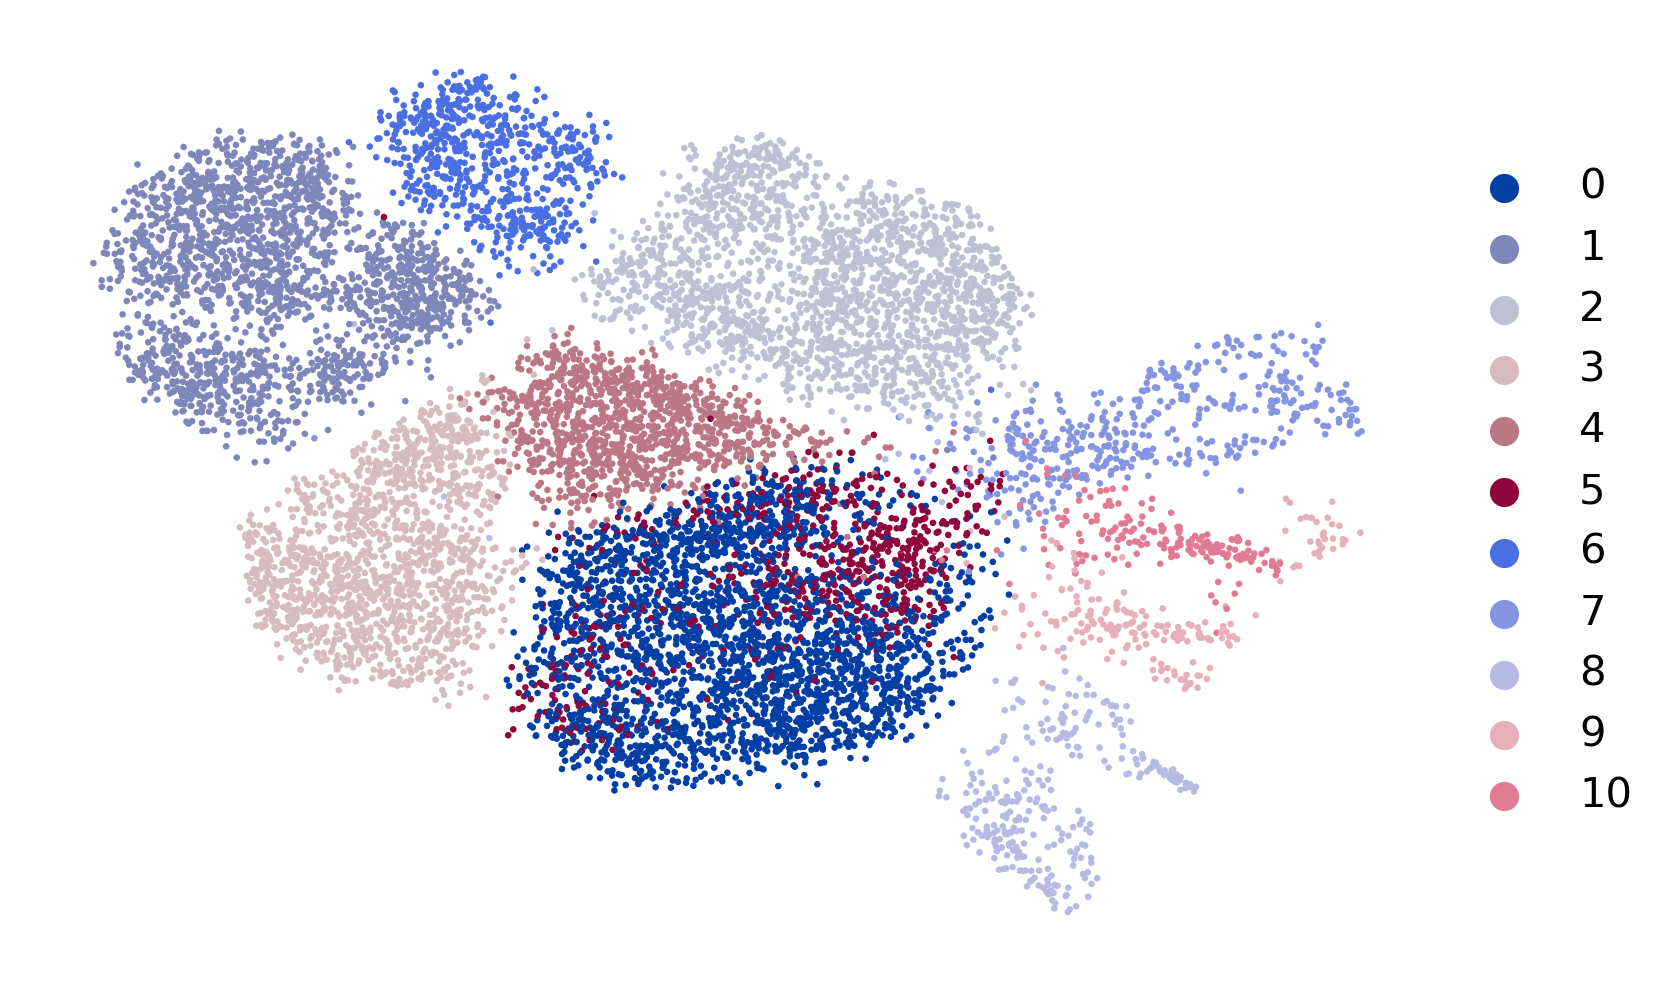

In [6]:
scv.pl.scatter(adata, title="", legend_loc='right margin', figsize=stream_figsize, save=f'{figure_path}/umap.png', dpi=300)

saving figure to file /nfs/turbo/umms-welchjd/yichen/figures/TopoVelo/simulation/spatial.png


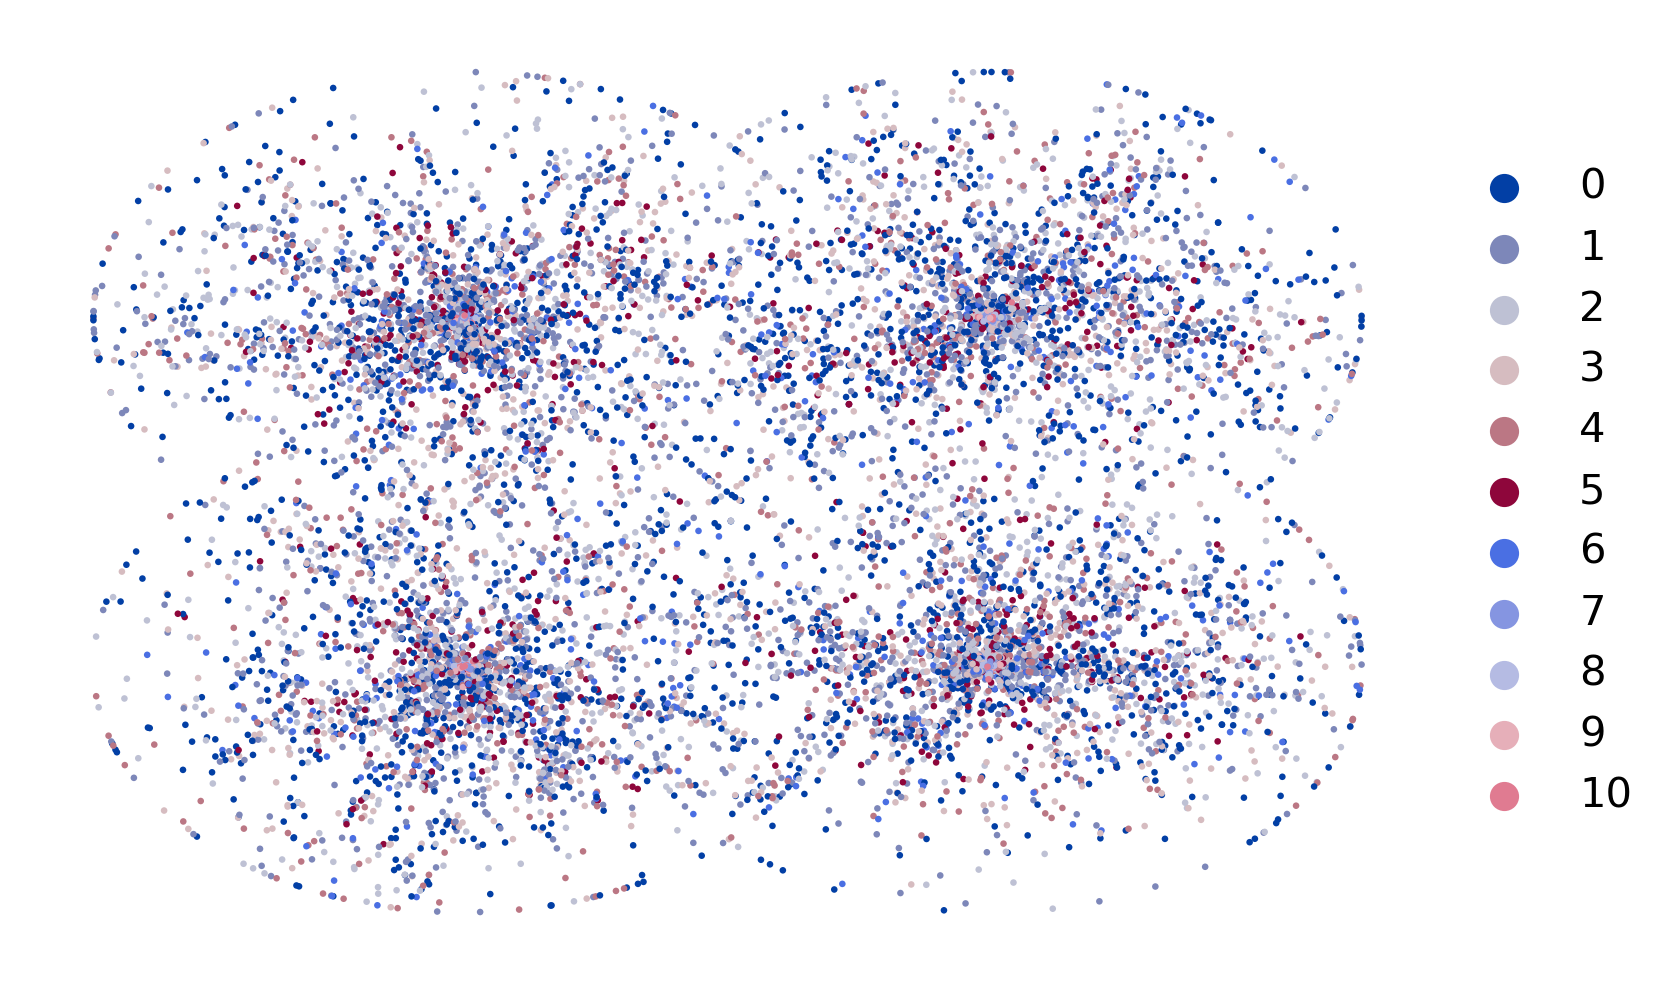

In [7]:
scv.pl.scatter(adata, basis='spatial', title="", legend_loc='right margin', figsize=stream_figsize, save=f'{figure_path}/spatial.png', dpi=300)

# TopoVelo

In [8]:
from sklearn.neighbors import NearestNeighbors
X_pos = adata.obsm['X_spatial']
nn = NearestNeighbors(n_neighbors=16)
nn.fit(X_pos)
adata.obsp['spatial_graph'] = nn.kneighbors_graph()

In [9]:
model_path = f'{model_path_base}/multiradial'
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              graph_decoder=True,
              attention=False,
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          embed='spatial')
vae.save_model(f'{model_path}/multiradial', 'encoder_tpv', 'decoder_tpv')
vae.save_anndata(adata, 'tpv', data_path, file_name="multiradial_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 271 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 2.]
Initial induction: 335, repression: 165/500
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 534.       *********
Summary: 
Train ELBO = 133.486
Test ELBO = 131.638
Total Time =   0 h : 19 m : 49 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/12000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.034
Average Neighborhood Size: 609.9
Average Set Size: 31.1
Summary: 
Train ELBO = 714.121
Test ELBO = 722.744
Total Time =   0 h : 21 m : 51 s

*********       Round 1: Early Stop Triggered at epoch 596.       *********
Change in noise variance: 0.4642
*********             Velocity Refinement Round 2              *********
Summary: 
Train ELBO = 663.112
Test ELBO = 716.428
Total Time =   0 h : 22 m : 50 s

*********       Round 2: Early Stop Triggered at epoch 628.       *********
Change in noise variance: 0.0012
Change in x0: 0.2801
*********             Velocity Refinement Round 3              *********
Summary: 
Train ELBO = 741.370
Test ELBO = 719.764
Total Time =   0 h : 23 m : 32 s

*********       Round 3: Early Stop Triggered at epoch 650.       *********
Change in noise variance: 0.0002
Change in x0: 0.2282
*********             Velocity Refinement Round 4              *********
Summary: 
Train ELBO = 695.863
Test ELBO = 717.578
Total Time =   0

In [3]:
adata = anndata.read_h5ad(f'{data_path}/multiradial_out.h5ad')

In [ ]:
model_path = f'{model_path_base}/multiradial'
vae = tpv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              graph_decoder=True,
              attention=True,
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata,
          adata.obsp['spatial_graph'],
          "X_spatial",
          config=config,
          plot=False,
          embed='spatial')
vae.save_model(f'{model_path}/multiradial', 'encoder_gat', 'decoder_gat')
vae.save_anndata(adata, 'gat', data_path, file_name="multiradial_out.h5ad")

Initialization using the steady-state and dynamical models.
Estimating ODE parameters...


  0%|          | 0/500 [00:00<?, ?it/s]

Detected 271 velocity genes.
Estimating the variance...


  0%|          | 0/500 [00:00<?, ?it/s]

3 clusters detected based on gene co-expression.
KS-test result: [1. 1. 2.]
Initial induction: 335, repression: 165/500
Initialization using the steady-state and dynamical models.
Reinitialize the regular ODE parameters based on estimated global latent time.


  0%|          | 0/500 [00:00<?, ?it/s]

--------------------------- Train a TopoVelo ---------------------------
*********               Creating a Graph Dataset              *********
*********                      Finished.                      *********
*********                 Creating optimizers                 *********
*********                      Finished.                      *********
*********                    Start training                   *********
*********                      Stage  1                       *********
*********       Stage 1: Early Stop Triggered at epoch 392.       *********
Summary: 
Train ELBO = 140.929
Test ELBO = 137.606
Total Time =   2 h : 23 m :  5 s

*********                      Stage  2                       *********
*********             Velocity Refinement Round 1              *********


  0%|          | 0/12000 [00:00<?, ?it/s]

Percentage of Invalid Sets: 0.031
Average Neighborhood Size: 609.9
Average Set Size: 32.8


# VeloVAE

In [ ]:
sys.path.insert(1, '../../../velovae')
import velovae as vv
import torch

In [ ]:
model_path = f'{model_path_base}/multiradial'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
              tmax=20, 
              dim_z=5, 
              device='cuda:0',
              reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='spatial')
vae.save_model(f'{model_path}/multiradial', 'encoder_vv', 'decoder_vv')
vae.save_anndata(adata, 'vv', data_path, file_name="multiradial_out.h5ad")

In [ ]:
model_path = f'{model_path_base}/multiradial'

torch.manual_seed(2022)
np.random.seed(2022)

vae = vv.VAE(adata, 
             tmax=20, 
             dim_z=5, 
             device='cuda:0',
             full_vb=True,
             reverse_gene_mode=False)
config = {
    'learning_rate': 2e-4,
    'learning_rate_ode': 2e-3,
    'learning_rate_post': 2e-4
}
vae.train(adata, config=config, plot=False, figure_path=figure_path, embed='spatial')
vae.save_model(f'{model_path}/multiradial', 'encoder_fullvb', 'decoder_fullvb')
vae.save_anndata(adata, 'fullvb', data_path, file_name="multiradial_out.h5ad")

# scVelo

In [ ]:
scv.tl.recover_dynamics(adata, n_jobs=8)
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)

In [ ]:
adata.obs['tprior'] = adata.obs['true_time'].to_numpy()
adata.write_h5ad(f'{data_path}/multiradial_out.h5ad')

# Manually annotate cell types

In [3]:
adata = anndata.read_h5ad(f'{data_path}/multiradial_out.h5ad')

In [4]:
n_type = 5
t = adata.obs['true_time'].to_numpy()
tmax, tmin = t.max(), t.min()
delta_t = (tmax - tmin) / n_type
cell_labels = np.array(['0']*adata.n_obs)
for i in range(4):
    cell_labels[(t >= tmin+delta_t*i) & (t <  tmin+delta_t*(i+1))] = str(i)
cell_labels[t >= tmin+delta_t*4] = '4'
print(np.unique(cell_labels))
adata.obs['clusters'] = cell_labels

['0' '1' '2' '3' '4']


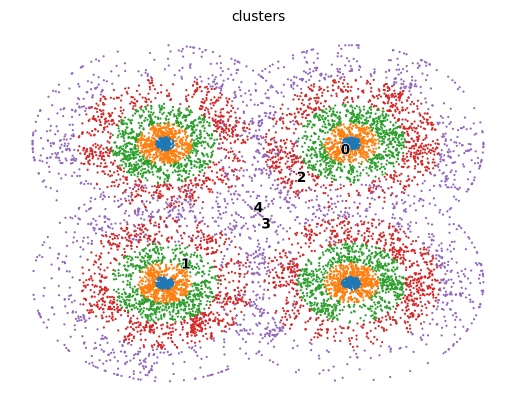

In [6]:
scv.pl.scatter(adata, basis='spatial', palette=tpv.get_colors(5))

# Performance Evaluation

In [7]:
cluster_edges = [('0', '1'),
                 ('1', '2'),
                 ('2', '3'),
                 ('3', '4')]
(res, res_type,
 res_multi, res_multi_type) = tpv.post_analysis(adata,
                                                'multiradial',
                                                ['scVelo', 'VeloVAE', 'VeloVAE (Rate Prior)', 'TopoVelo (GCN)', 'TopoVelo (GAT)'],
                                                ['fit', 'vv', 'fullvb', 'tpv', 'gat'],
                                                spatial_graph_key='spatial_graph',
                                                spatial_key='X_spatial',
                                                compute_metrics=True,
                                                genes=np.random.choice(adata.var_names, 4),
                                                grid_size=(1, 4),
                                                embed='spatial',
                                                plot_type=[],
                                                cluster_edges=cluster_edges)

*** Computing performance metrics 1/5 ***
computing velocity graph (using 6/36 cores)


  0%|          | 0/12000 [00:00<?, ?cells/s]

    finished (0:00:35) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 2/5 ***
computing velocity graph (using 6/36 cores)


  0%|          | 0/12000 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'vv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'vv_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 3/5 ***
computing velocity graph (using 6/36 cores)


  0%|          | 0/12000 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'fullvb_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'fullvb_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 4/5 ***
computing velocity graph (using 6/36 cores)


  0%|          | 0/12000 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'tpv_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'tpv_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

*** Computing performance metrics 5/5 ***
computing velocity graph (using 6/36 cores)


  0%|          | 0/12000 [00:00<?, ?cells/s]

    finished (0:00:21) --> added 
    'gat_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:03) --> added
    'gat_velocity_spatial', embedded velocity vectors (adata.obsm)
Finished. 

---     Integrating Peformance Metrics     ---
Dataset Size: 12000 cells, 500 genes
---   Plotting  Results   ---


In [8]:
perf_logger = tpv.PerfLogger(save_path='/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf',
                             checkpoints = ['/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf/simulation.csv',
                                            '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf/simulation_type.csv',
                                            '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf/simulation_multi.csv',
                                            '/nfs/turbo/umms-welchjd/yichen/data/TopoVelo/perf/simulation_multi_type.csv'])
perf_logger.insert('Radial', res, res_type, res_multi, res_multi_type)

In [9]:
perf_logger.df.loc[['Time Correlation', 'Spatial Velocity Consistency', 'Spatial Time Consistency', 'CBDir']]

Bidirectional  Radial
Metrics                      Model                                      
Time Correlation             scVelo                        0.428   0.257
                             VeloVAE                       0.895   0.725
                             VeloVAE (Rate Prior)          0.908   0.833
                             TopoVelo (GCN)                0.950   0.915
                             TopoVelo (GAT)                0.990   0.967
Spatial Velocity Consistency scVelo                        0.372   0.683
                             VeloVAE                       0.859   0.726
                             VeloVAE (Rate Prior)          0.891   0.797
                             TopoVelo (GCN)                0.973   0.876
                             TopoVelo (GAT)                0.987   0.968
Spatial Time Consistency     scVelo                        0.471   0.402
                             VeloVAE                       0.866   0.889
                             VeloVAE (Rate Prior)          0.865   0.940
                             TopoVelo (GCN)                0.965   0.975
                             TopoVelo (GAT)                0.990   0.992
CBDir                        scVelo                        0.279   0.317
                             VeloVAE                       0.756   0.468
                             VeloVAE (Rate Prior)          0.767   0.474
                             TopoVelo (GCN)                0.767   0.446
                             TopoVelo (GAT)                0.767   0.531

In [10]:
perf_logger.save('simulation')